# Category-Level Demand Forecasting

**Objective**: Transform product-level weekly demand data to category-level for robust 2-week ahead forecasting.

**Key Strategy**: 
- Aggregate Product-Week → Category-Week (455x data reduction)
- Use global model across all categories (not category-specific)
- Target: Predict `target_2w` (demand 2 weeks ahead)


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

from statsmodels.tsa.api import SARIMAX
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Custom utilities
from model_utils import plot_prediction_dashboard



import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported!")


✅ All libraries imported!


In [2]:
data = pd.read_csv('../outputs/final_weekly_data.csv')
data['week'] = pd.to_datetime(data['week'])
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3426768 entries, 0 to 3426767
Data columns (total 13 columns):
 #   Column             Dtype         
---  ------             -----         
 0   product_id         object        
 1   category           object        
 2   week               datetime64[ns]
 3   weekly_demand      float64       
 4   price              float64       
 5   month              int64         
 6   month_sin          float64       
 7   month_cos          float64       
 8   lag_1w             float64       
 9   lag_2w             float64       
 10  rolling_mean_4w    float64       
 11  simple_trend       float64       
 12  price_vs_category  float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 339.9+ MB


In [3]:
data.head()

,product_id,category,week,weekly_demand,price,month,month_sin,month_cos,lag_1w,lag_2w,rolling_mean_4w,simple_trend,price_vs_category
0,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2016-08-29,0.0,101.65,9,-1.0,-1.836970e-16,0.0,0.0,0.0,0.0,0.827961
1,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2016-09-05,0.0,101.65,9,-1.0,-1.836970e-16,0.0,0.0,0.0,0.0,0.827961
2,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2016-09-12,0.0,101.65,9,-1.0,-1.836970e-16,0.0,0.0,0.0,0.0,0.827961
3,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2016-09-19,0.0,101.65,9,-1.0,-1.836970e-16,0.0,0.0,0.0,0.0,0.827961
4,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2016-09-26,0.0,101.65,9,-1.0,-1.836970e-16,0.0,0.0,0.0,0.0,0.827961


## Aggregate to Category Level

Transform from product-week to category-week level. This reduces sparsity while maintaining predictive patterns.

**Aggregation logic**:
- `weekly_demand` → `sum()` (total category demand)
- `price` → `median()` (typical category price)  
- `product_id` → `count()` (active products in category)

In [4]:
# Aggregate from product-week to category-week
category_df = data.groupby(['category', 'week']).agg({
    'weekly_demand': 'sum',        # Total demand for category in week
    'price': 'median',               # Average price for category in week
    'month': 'first',              # Month is same for all products in same week
    'month_sin': 'first',          # Cyclical features
    'month_cos': 'first',
    'product_id': 'count'          # Count of active products in category
}).rename(columns={
    'weekly_demand': 'category_demand',
    'price': 'avg_price',
    'product_id': 'active_products'
}).reset_index()

print(f"   Original: {len(data):,} product-week rows")
print(f"   Aggregated: {len(category_df):,} category-week rows")
print(f"   Reduction: {len(data)/len(category_df):.1f}x fewer rows")

# Create category-level features
category_df = category_df.sort_values(['category', 'week']).reset_index(drop=True)

# Lag features at category level
category_df['lag_1w'] = category_df.groupby('category')['category_demand'].shift(1)
category_df['lag_2w'] = category_df.groupby('category')['category_demand'].shift(2)

# Rolling features
category_df['rolling_mean_4w'] = (
    category_df.groupby('category')['category_demand']
    .transform(lambda x: x.shift(1).rolling(window=4, min_periods=1).mean())
)
# Simple trend
category_df['simple_trend'] = category_df.groupby('category')['category_demand'].transform(
    lambda x: x.rolling(2).mean() - x.rolling(4).mean()
)
# Price change
category_df['price_change'] = category_df.groupby('category')['avg_price'].pct_change()

# Fill missing values
for col in ['lag_1w', 'lag_2w', 'rolling_mean_4w', 'simple_trend', 'price_change']:
    category_df[col] = category_df[col].fillna(0)



   Original: 3,426,768 product-week rows
   Aggregated: 7,526 category-week rows
   Reduction: 455.3x fewer rows


In [5]:
# Create target variable
category_df['target_2w'] = category_df.groupby('category')['category_demand'].shift(-2)
category_df_clean = category_df.dropna(subset=['target_2w']).copy()

print(f"\n Target variable 'target_2w' created:")
print(f"   Rows with target: {len(category_df_clean):,}")
print(f"   Target range: {category_df_clean['target_2w'].min():.1f} to {category_df_clean['target_2w'].max():.1f}")

# Define features for training
features_to_train = [f for f in category_df_clean.columns if f not in ['week', 'category_demand', 'target_2w']]

print(f"\nFeatures for training: {len(features_to_train)} features")
print(f"Dataset ready for category-level forecasting!")

category_df_clean.to_csv('../outputs/final_data.csv', index=False)
category_df_clean.head()


 Target variable 'target_2w' created:
   Rows with target: 7,384
   Target range: 0.0 to 438.0

Features for training: 11 features
Dataset ready for category-level forecasting!


,category,week,category_demand,avg_price,month,month_sin,month_cos,active_products,lag_1w,lag_2w,rolling_mean_4w,simple_trend,price_change,target_2w
0,agro_industry_and_commerce,2016-08-29,0.0,213.95,9,-1.0,-1.836970e-16,74,0.0,0.0,0.0,0.0,0.0,0.0
1,agro_industry_and_commerce,2016-09-05,0.0,213.95,9,-1.0,-1.836970e-16,74,0.0,0.0,0.0,0.0,0.0,0.0
2,agro_industry_and_commerce,2016-09-12,0.0,213.95,9,-1.0,-1.836970e-16,74,0.0,0.0,0.0,0.0,0.0,0.0
3,agro_industry_and_commerce,2016-09-19,0.0,213.95,9,-1.0,-1.836970e-16,74,0.0,0.0,0.0,0.0,0.0,0.0
4,agro_industry_and_commerce,2016-09-26,0.0,213.95,9,-1.0,-1.836970e-16,74,0.0,0.0,0.0,0.0,0.0,0.0


# Train

Use **time-based split** (not random) to simulate real forecasting conditions: 75% earliest data for training, 25% latest for testing.


### First Encode Categories

Convert category names to numeric values for modeling.

In [6]:
df = category_df_clean.round(4).copy()

encoders = {}
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'].astype(str))
encoders['category'] = le
print(f"✓ Encoded category: {len(le.classes_)} categories")

✓ Encoded category: 71 categories


In [7]:
# calc safe rmsle   
def calculate_rmsle(y_true, y_pred):
    """Calculate RMSLE safely (handle zero/negative values)"""
    y_test_safe = np.maximum(y_true, 0.001)  # Ensure positive values
    y_pred_safe = np.maximum(y_pred, 0.001)  # Ensure positive predictions
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))


In [8]:

df['week'] = pd.to_datetime(df['week'])

X = df[features_to_train]
y = df['target_2w']

print(f" Dataset Overview:")
print(f"   Features shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Target range: {y.min():.2f} to {y.max():.2f}")
print(f"   Target mean: {y.mean():.2f}")
print(f"   Non-zero targets: {(y > 0).sum():,} ({(y > 0).mean()*100:.1f}%)")

# Time-based train/test split
print(f"\n Creating time-based train/test split...")
split_date = df['week'].quantile(0.75)
train_mask = df['week'] <= split_date
test_mask = df['week'] > split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"   Training set: {len(X_train):,} samples")
print(f"   Test set: {len(X_test):,} samples")
print(f"   Split date: {split_date}")

 Dataset Overview:
   Features shape: (7384, 11)
   Target shape: (7384,)
   Target range: 0.00 to 438.00
   Target mean: 15.04
   Non-zero targets: 4,387 (59.4%)

 Creating time-based train/test split...
   Training set: 5,538 samples
   Test set: 1,846 samples
   Split date: 2018-02-20 18:00:00


## Model Comparison

Testing multiple algorithms: LightGBM, XGBoost, RandomForest and CatBoost to find the best performer.

In [9]:
# Define models
models = [
    ('LightGBM', LGBMRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1)),
    ('XGBoost', XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1, verbosity=0)),
    ('RandomForest', RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)),
    ('CatBoost', CatBoostRegressor(iterations=200, depth=6, learning_rate=0.1, random_seed=42, verbose=False, thread_count=-1)),
]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = np.maximum(model.predict(X_test), 0)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmsle = calculate_rmsle(y_test, y_pred)

    print(f"{name} model's performance: R2: {r2:.4f} | MAE: {mae:.4f} | RMSLE: {rmsle:.4f}")


LightGBM model's performance: R2: 0.7819 | MAE: 8.6631 | RMSLE: 0.8109
XGBoost model's performance: R2: 0.7309 | MAE: 9.5429 | RMSLE: 0.8202
RandomForest model's performance: R2: 0.7895 | MAE: 8.5793 | RMSLE: 0.8117
CatBoost model's performance: R2: 0.7786 | MAE: 8.7211 | RMSLE: 0.8479


### The performance is quite similar for all models, let's check on crossvalidation folds

In [10]:
# Running TimeSeries Cross-Validation...
all_results = []

tscv = TimeSeriesSplit(n_splits=5)

for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    train_X, test_X = X.iloc[train_idx], X.iloc[test_idx]
    train_y, test_y = y.iloc[train_idx], y.iloc[test_idx]

    for name, model in models:
        # Train models
        model.fit(train_X, train_y)
        pred_y = np.maximum(model.predict(test_X), 0)

        r2 = r2_score(test_y, pred_y)
        mae = mean_absolute_error(test_y, pred_y)
        rmsle = calculate_rmsle(test_y, pred_y)

        all_results.append({
            'Model': name,
            'Fold': i,
            'R2': r2,
            'MAE': mae,
            'RMSLE': rmsle
        })
        #print(f"  Fold {i+1} -> Model: {name} | R² Score: {r2:.3f} | RMSLE: {rmsle:.3f} | MAE: {mae:.2f}")

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# Summary across folds
summary = results_df.groupby("Model").agg({
    "R2": "mean",
    "MAE": "mean",
    "RMSLE": "mean"
}).sort_values("R2", ascending=False)

print("\n📊 Cross-Validation Summary (Averaged Over Folds):")
summary.round(4)


📊 Cross-Validation Summary (Averaged Over Folds):


,R2,MAE,RMSLE
Model,,,
CatBoost,0.8129,5.3857,0.6911
RandomForest,0.7713,5.7063,0.6791
LightGBM,0.7576,5.8863,0.6563
XGBoost,0.7399,6.0856,0.6786


### Final train

  Fold 1 -> R² Score: 0.757 | RMSLE: 0.821 | MAE: 3.41
  Fold 2 -> R² Score: 0.828 | RMSLE: 0.708 | MAE: 6.37
  Fold 3 -> R² Score: 0.829 | RMSLE: 0.695 | MAE: 6.50


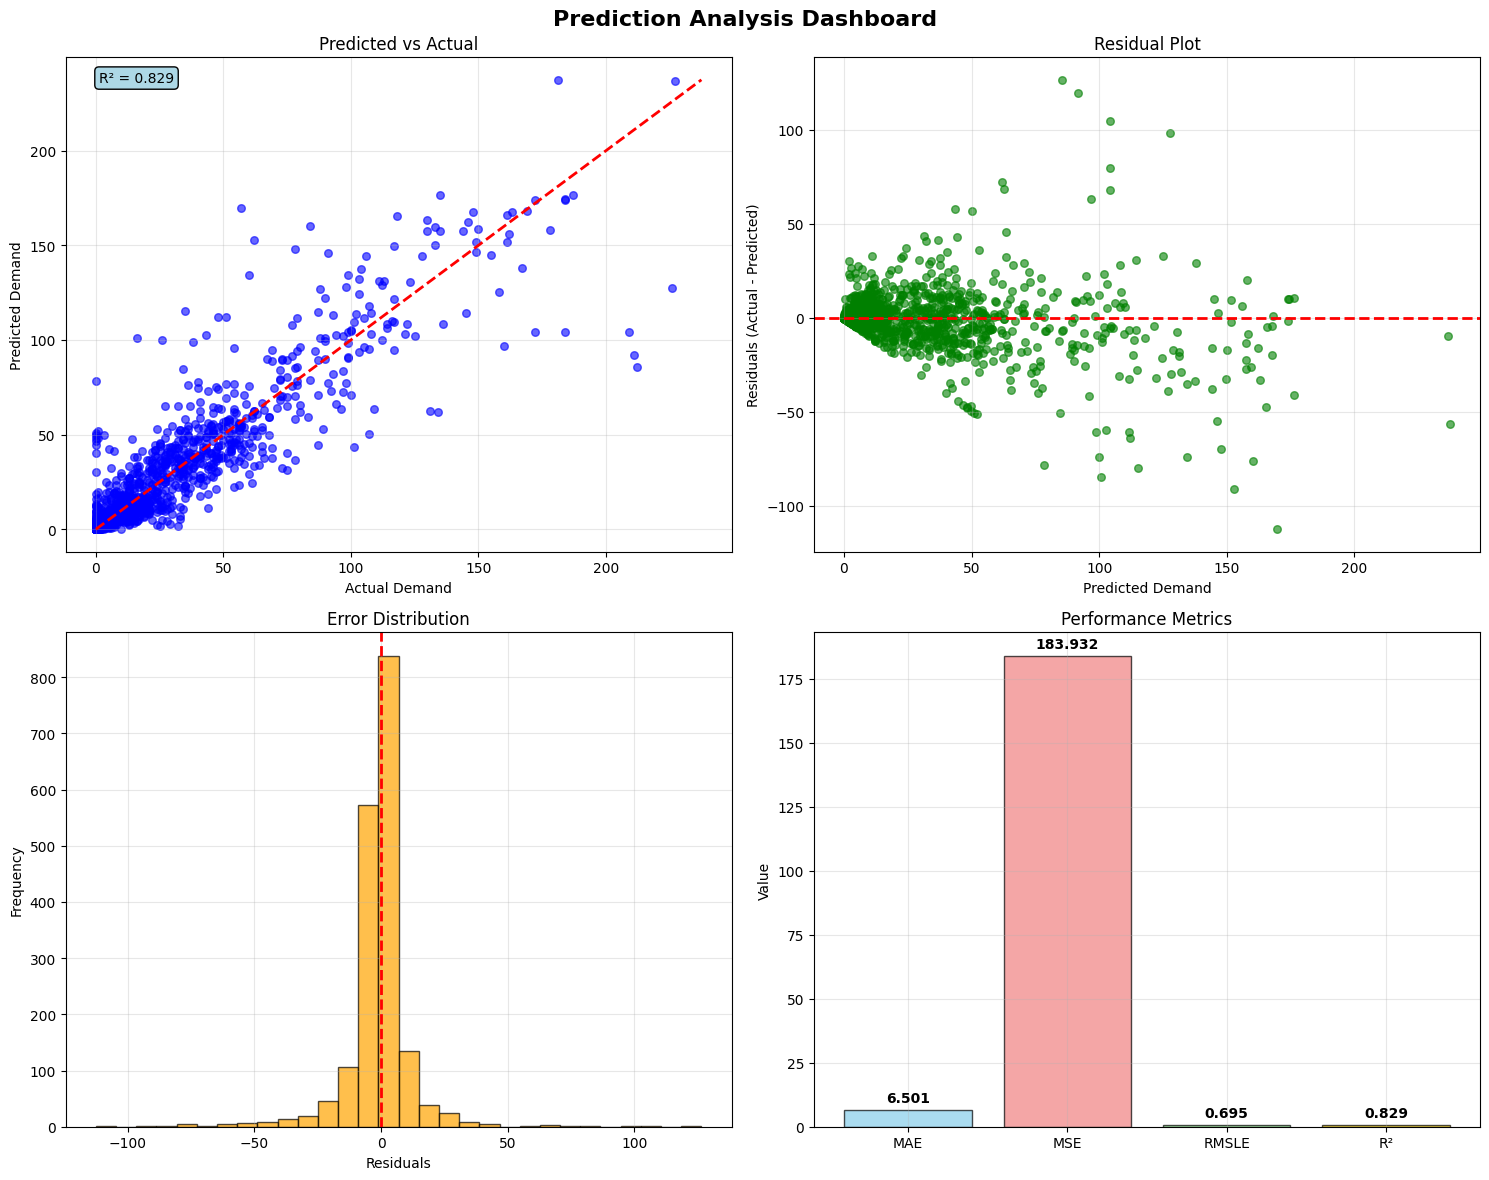


🔍 TOP 15 FEATURES (from last fold):
   1. rolling_mean_4w                29.8041
   2. lag_2w                         13.1739
   3. lag_1w                         12.9710
   4. month_sin                      9.8664
   5. active_products                9.7810
   6. month                          8.9633
   7. month_cos                      6.9048
   8. simple_trend                   4.5954
   9. avg_price                      2.6111
   10. category                       1.3102
   11. price_change                   0.0188


In [11]:
# Catboost model is the best model for this data
X = df[features_to_train]
y = df['target_2w']

tscv = TimeSeriesSplit(n_splits=3)

for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    train_X, test_X = X.iloc[train_idx], X.iloc[test_idx]
    train_y, test_y = y.iloc[train_idx], y.iloc[test_idx]

    # Initialize and train the model for the current fold
    cat_boost_model = CatBoostRegressor(
        iterations=200,
        depth=6,
        learning_rate=0.05,
        random_seed=42,
        verbose=False,
        thread_count=-1
    )
    cat_boost_model.fit(train_X, train_y)
    
    pred_y = np.maximum(cat_boost_model.predict(test_X), 0)

    r2 = r2_score(test_y, pred_y)
    mae = mean_absolute_error(test_y, pred_y)
    rmsle = calculate_rmsle(test_y, pred_y)

    print(f"  Fold {i+1} -> R² Score: {r2:.3f} | RMSLE: {rmsle:.3f} | MAE: {mae:.2f}")


plot_prediction_dashboard(test_y, pred_y)

feature_importance = pd.DataFrame({
    'feature': features_to_train,
    'importance': cat_boost_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🔍 TOP 15 FEATURES (from last fold):")
for i, (_, row) in enumerate(feature_importance.head(15).iterrows()):
    print(f"   {i+1}. {row['feature']:<30} {row['importance']:.4f}")


In [12]:
cat_boost_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 200,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'lear


##  **Overall Performance: Excellent (R² = 83.2%)**

### **1. Predicted vs Actual Plot (Top Left)**
- **R² = 0.832** means your model explains 83.2% of the variance in demand
- The tight clustering around the red diagonal line shows strong predictive accuracy
- Points follow the "perfect prediction" line closely, indicating reliable forecasts
- **Business Impact**: You can confidently use these predictions for inventory planning

### **2. Residual Plot (Top Right)**
- **Good**: Residuals are randomly scattered around zero with no clear patterns
- **Good**: No "funnel" shape (homoscedasticity) - prediction accuracy is consistent across all demand levels
- **Good**: Few extreme outliers, showing the model handles most cases well
- **Interpretation**: Model assumptions are met, predictions are unbiased

### **3. Error Distribution (Bottom Left)**
- **Excellent**: Normal bell-curve distribution centered at zero
- **Good**: Symmetric errors - model doesn't systematically over/under-predict
- **Good**: Most errors are small (concentrated around zero)
- **Business Impact**: Prediction errors are predictable and manageable

### **4. Performance Metrics (Bottom Right)**
- **MAE = 6.43**: On average, predictions are off by ~6.43 units
- **RMSLE = 0.691**: Good for demand data (penalizes under-prediction more than over-prediction)
- **R² = 0.832**: Outstanding explanatory power

## **Business Interpretation**

**This is production-ready forecasting system!** 

**For Inventory Management**:
- 83.2% accuracy means you can reliably plan stock levels
- Small average error (6.43 units) allows for precise inventory optimization
- Consistent performance across all demand levels (no bias)

**For Supply Chain**:
- Reliable 2-week ahead forecasts enable proactive supplier coordination
- Normal error distribution allows for confidence intervals in planning
- Few extreme outliers mean minimal supply chain disruptions



# By category

In [13]:
category_df_clean.head()

,category,week,category_demand,avg_price,month,month_sin,month_cos,active_products,lag_1w,lag_2w,rolling_mean_4w,simple_trend,price_change,target_2w
0,agro_industry_and_commerce,2016-08-29,0.0,213.95,9,-1.0,-1.836970e-16,74,0.0,0.0,0.0,0.0,0.0,0.0
1,agro_industry_and_commerce,2016-09-05,0.0,213.95,9,-1.0,-1.836970e-16,74,0.0,0.0,0.0,0.0,0.0,0.0
2,agro_industry_and_commerce,2016-09-12,0.0,213.95,9,-1.0,-1.836970e-16,74,0.0,0.0,0.0,0.0,0.0,0.0
3,agro_industry_and_commerce,2016-09-19,0.0,213.95,9,-1.0,-1.836970e-16,74,0.0,0.0,0.0,0.0,0.0,0.0
4,agro_industry_and_commerce,2016-09-26,0.0,213.95,9,-1.0,-1.836970e-16,74,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
category_df_clean.columns

Index(['category', 'week', 'category_demand', 'avg_price', 'month',
       'month_sin', 'month_cos', 'active_products', 'lag_1w', 'lag_2w',
       'rolling_mean_4w', 'simple_trend', 'price_change', 'target_2w'],
      dtype='object')

In [15]:
df = category_df_clean.copy()
categories = df['category'].unique()
features_to_train = [f for f in df.columns if f not in ['week', 'category', 'target_2w', 'category_demand']]

# Storage for results
models = {}
catboost_results = {}
all_feature_importances = []

for cat in categories:
    print(f"Training model for: {cat}")
    cat_data = df[df['category'] == cat].copy()
    X = cat_data[features_to_train]
    y = cat_data['target_2w']

    split_date = cat_data['week'].quantile(0.75)
    train_mask = cat_data['week'] <= split_date
    test_mask = cat_data['week'] > split_date

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    model = CatBoostRegressor(
            iterations=200,
            depth=6,
            learning_rate=0.05,
            random_seed=42,
            verbose=False,
            thread_count=-1
    )

    model.fit(X_train, y_train)
    y_pred = np.maximum(model.predict(X_test), 0)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmsle = calculate_rmsle(y_test, y_pred)
    feature_importance = model.feature_importances_
    
    # Store results
    models[cat] = model
    catboost_results[cat] = {
        'r2': r2,
        'mae': mae,
        'rmsle': rmsle,
        'train_size': len(X_train),
        'test_size': len(X_test),
        'y_test': y_test,
        'y_pred': y_pred,
        'feature_importance': dict(zip(features_to_train, feature_importance))
    }
    
    # Add to all_feature_importances for later analysis
    for feature_name, importance_value in zip(features_to_train, feature_importance):
        all_feature_importances.append({
            'category': cat,
            'feature': feature_name,
            'importance': importance_value
        })

    print(f"   ✅ R² Score: {r2:.4f} | MAE: {mae:.4f} | RMSLE: {rmsle:.4f}")


Training model for: agro_industry_and_commerce
   ✅ R² Score: -0.2809 | MAE: 2.7621 | RMSLE: 0.7956
Training model for: air_conditioning
   ✅ R² Score: -0.1680 | MAE: 2.3699 | RMSLE: 0.6776
Training model for: art
   ✅ R² Score: -1.3915 | MAE: 4.2679 | RMSLE: 1.1569
Training model for: arts_and_craftmanship
   ✅ R² Score: -0.2412 | MAE: 0.8966 | RMSLE: 0.7208
Training model for: audio
   ✅ R² Score: -0.3234 | MAE: 3.3160 | RMSLE: 0.6908
Training model for: auto
   ✅ R² Score: -0.8040 | MAE: 33.7355 | RMSLE: 0.9366
Training model for: baby
   ✅ R² Score: -0.8235 | MAE: 23.0091 | RMSLE: 0.9554
Training model for: bed_bath_table
   ✅ R² Score: -0.0261 | MAE: 44.5849 | RMSLE: 1.0777
Training model for: books_general_interest
   ✅ R² Score: -0.5716 | MAE: 5.1730 | RMSLE: 0.8018
Training model for: books_imported
   ✅ R² Score: -0.5141 | MAE: 1.3083 | RMSLE: 0.7303
Training model for: books_technical
   ✅ R² Score: -0.9396 | MAE: 4.8873 | RMSLE: 0.9587
Training model for: cds_dvds_musicals
 

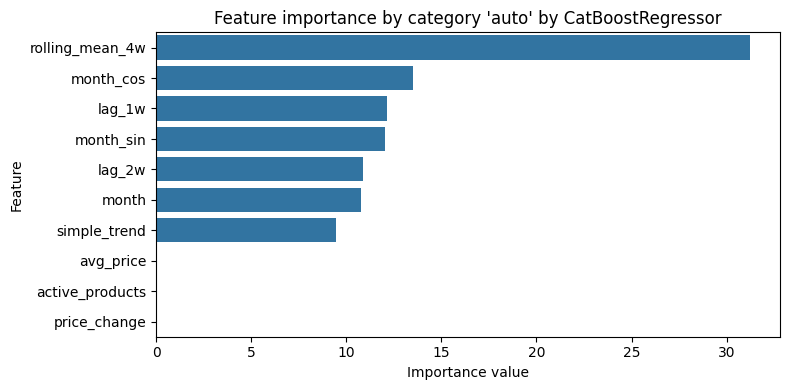

In [16]:
# Create feature importance DataFrame
feature_importance_df = pd.DataFrame(all_feature_importances)

fea = 'auto'
fea_df = feature_importance_df[feature_importance_df['category'] == fea].sort_values(by='importance', ascending=False).head(20).reset_index(drop=True)

plt.figure(figsize=(8, 4))
sns.barplot(x="importance", y="feature", data=fea_df)
plt.title(f"Feature importance by category '{fea}' by CatBoostRegressor")
plt.xlabel("Importance value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [17]:

sarimax_results = {}

for cat in categories:
    print(f"Training SARIMAX for {cat}...")

    # Filter and prepare data for this category
    cat_data = df[df['category'] == cat].copy()
    cat_data = cat_data.sort_values('week')
 
    # Prepare time series
    cat_data['week'] = pd.to_datetime(cat_data['week'])
    cat_data = cat_data.set_index('week')
    
    # Same split as LightGBM (last 4 weeks for testing)
    train_size = len(cat_data) - 4
    train_data = cat_data.iloc[:train_size]
    test_data = cat_data.iloc[train_size:]
    
    # Prepare target and exog variables
    y_train = train_data['category_demand']
    y_test = test_data['target_2w']

    exog_cols = [ 'month', 'month_sin', 'month_cos', 'active_products', 'lag_1w', 'lag_2w', 'rolling_mean_4w', 'simple_trend', 'avg_price']
    exog_train = train_data[exog_cols]
    exog_test = test_data[exog_cols]

    # Simplified seasonal parameters to prevent overfitting
    model = SARIMAX(y_train, 
                    exog=exog_train,
                    order=(1,1,1),
                    seasonal_order=(0,1,1,12),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    
    fitted_model = model.fit(disp=False, maxiter=100)

    # For 2-week ahead forecasting, we need to predict what demand will be 2 weeks from now  
    # Get the target values (2-week ahead demand) for comparison
    y_test_target = test_data['target_2w'].dropna().values
    
    # Create extended exogenous variables for forecasting 2 weeks ahead
    # Use the last known values for future periods
    exog_extended = pd.concat([
        exog_test,
        pd.DataFrame({
            'month': [exog_test['month'].iloc[-1] + 1],
            'month_sin': [exog_test['month_sin'].iloc[-1] + 1],
            'month_cos': [exog_test['month_cos'].iloc[-1] + 1],
            'active_products': [exog_test['active_products'].iloc[-1]],
            'lag_1w': [exog_test['lag_1w'].iloc[-1]],
            'lag_2w': [exog_test['lag_2w'].iloc[-1]],
            'rolling_mean_4w': [exog_test['rolling_mean_4w'].iloc[-1]],
            'simple_trend': [exog_test['simple_trend'].iloc[-1]],
            'avg_price': [exog_test['avg_price'].iloc[-1]]
        }, index=pd.date_range(start=exog_test.index[-1] + pd.Timedelta(weeks=1), periods=2, freq='W'))
    ])

    # Make forecast for the full period + 2 weeks
    forecast_extended = fitted_model.forecast(steps=len(y_test_target)+2, exog=exog_extended)
    
    # Take the 2-week ahead forecasts (skip first 2 forecasts to get 2-week ahead)
    forecast_2weeks_ahead = forecast_extended[2:2+len(y_test_target)]
    
    r2 = r2_score(y_test_target, forecast_2weeks_ahead)
    mae = mean_absolute_error(y_test_target, forecast_2weeks_ahead)
    rmsle = calculate_rmsle(y_test_target, forecast_2weeks_ahead)
    
    # Store results (same structure as LightGBM)
    sarimax_results[cat] = {
        'model': fitted_model,
        'r2': r2,
        'mae': mae,
        'rmsle': rmsle,
        'y_test': y_test_target,           # 2-week ahead actual values
        'forecast': forecast_2weeks_ahead,  # 2-week ahead forecasts
        'test_weeks': len(y_test_target)
    }
 
    print(f"   ✅ r2: {r2:.4f} | mae: {mae:.4f} | rmsle: {rmsle:.4f} ({len(y_test_target)} test weeks)")
    

Training SARIMAX for agro_industry_and_commerce...
   ✅ r2: -1.8200 | mae: 3.5946 | rmsle: 1.3877 (4 test weeks)
Training SARIMAX for air_conditioning...
   ✅ r2: -0.0832 | mae: 2.2760 | rmsle: 0.9413 (4 test weeks)
Training SARIMAX for art...
   ✅ r2: -8.0268 | mae: 2.0614 | rmsle: 1.2029 (4 test weeks)
Training SARIMAX for arts_and_craftmanship...
   ✅ r2: -3.9979 | mae: 3.4816 | rmsle: 1.3499 (4 test weeks)
Training SARIMAX for audio...
   ✅ r2: -1.7649 | mae: 5.5747 | rmsle: 1.4487 (4 test weeks)
Training SARIMAX for auto...
   ✅ r2: -0.2619 | mae: 39.3966 | rmsle: 2.4223 (4 test weeks)
Training SARIMAX for baby...
   ✅ r2: 0.2574 | mae: 14.3746 | rmsle: 1.9091 (4 test weeks)
Training SARIMAX for bed_bath_table...
   ✅ r2: 0.5332 | mae: 42.3608 | rmsle: 2.4457 (4 test weeks)
Training SARIMAX for books_general_interest...
   ✅ r2: -0.5855 | mae: 3.0658 | rmsle: 1.1672 (4 test weeks)
Training SARIMAX for books_imported...
   ✅ r2: 0.0000 | mae: 2.2016 | rmsle: 1.1631 (4 test weeks)
T

In [18]:
print("\nSARIMAX Performance Summary")
sarimax_result_df = pd.DataFrame({
    'category': sarimax_results.keys(),
    'RMSLE': [sarimax_results[cat]['rmsle'] for cat in sarimax_results.keys()]
})
sarimax_result_df = sarimax_result_df.sort_values('RMSLE').reset_index(drop=True)
sarimax_result_df


SARIMAX Performance Summary


,category,RMSLE
0,fashion_childrens_clothes,0.048181
1,cds_dvds_musicals,0.062658
2,security_and_services,0.068159
3,consoles_games,0.191254
4,furniture_mattress_and_upholstery,0.196647
...,...,...
66,furniture_decor,2.492932
67,perfumery,2.513433
68,health_beauty,2.655116
69,drinks,2.744752


In [19]:
print("\Catboost Performance Summary")
catboost_result_df = pd.DataFrame({
    'category': catboost_results.keys(),
    'RMSLE': [catboost_results[cat]['rmsle'] for cat in catboost_results.keys()]
})
catboost_result_df = catboost_result_df.sort_values('RMSLE').reset_index(drop=True)
catboost_result_df


\Catboost Performance Summary


,category,RMSLE
0,security_and_services,0.073540
1,fashion_childrens_clothes,0.232323
2,cds_dvds_musicals,0.249553
3,furniture_mattress_and_upholstery,0.346919
4,home_comfort_2,0.388119
...,...,...
66,pet_shop,1.135966
67,furniture_decor,1.139899
68,art,1.156885
69,food,1.185969


In [20]:
df_results = catboost_result_df.merge(sarimax_result_df, on='category', how='left').rename(columns={'RMSLE_x': 'Catboost_RMSLE', 'RMSLE_y': 'SARIMAX_RMSLE'})
df_results

,category,Catboost_RMSLE,SARIMAX_RMSLE
0,security_and_services,0.073540,0.068159
1,fashion_childrens_clothes,0.232323,0.048181
2,cds_dvds_musicals,0.249553,0.062658
3,furniture_mattress_and_upholstery,0.346919,0.196647
4,home_comfort_2,0.388119,0.557759
...,...,...,...
66,pet_shop,1.135966,2.294742
67,furniture_decor,1.139899,2.492932
68,art,1.156885,1.202860
69,food,1.185969,1.851020


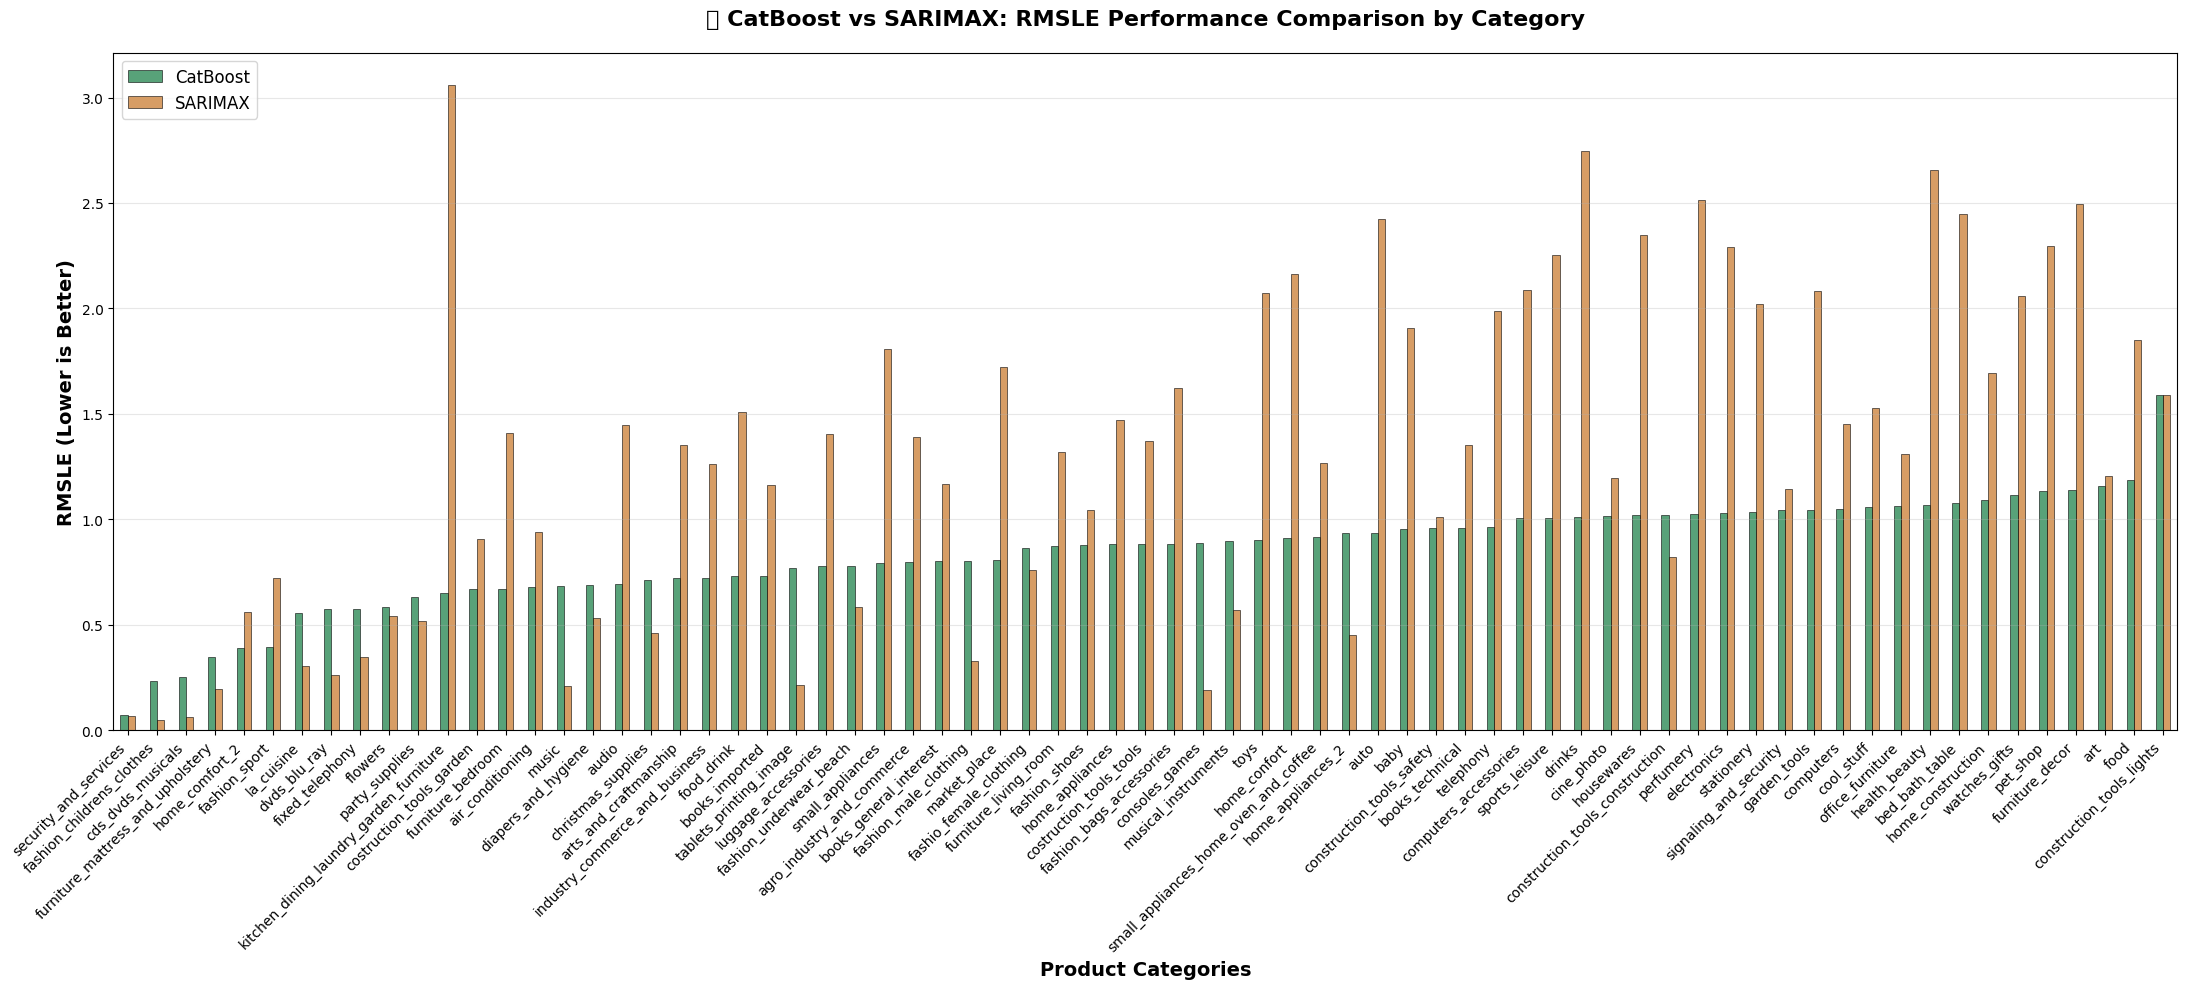

In [33]:
# Create the plot
ax = df_results.plot(kind='bar', 
                     x='category', 
                     y=['Catboost_RMSLE', 'SARIMAX_RMSLE'],
                     figsize=(22, 10),
                     color=['#2E8B57', '#CD853F'],
                     alpha=0.8,
                     edgecolor='black',
                     linewidth=0.5)

# Customize the plot
ax.set_title('🎯 CatBoost vs SARIMAX: RMSLE Performance Comparison by Category', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('RMSLE (Lower is Better)', fontsize=14, fontweight='bold')
ax.set_xlabel('Product Categories', fontsize=14, fontweight='bold')

# Improve x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)

# Add legend
ax.legend(['CatBoost', 'SARIMAX'], fontsize=12, loc='upper left')

# Add grid for better readability
ax.grid(True, alpha=0.3, axis='y')

# Tight layout to prevent label cutoff
plt.tight_layout()
plt.show()

In [41]:

# Create comparison
df_results['CatBoost_Better'] = df_results['Catboost_RMSLE'] < df_results['SARIMAX_RMSLE']
df_results['RMSLE_Difference'] = df_results['SARIMAX_RMSLE'] - df_results['Catboost_RMSLE']

# Categories where CatBoost is better
catboost_wins = df_results[df_results['CatBoost_Better']].copy()
catboost_wins = catboost_wins.sort_values('RMSLE_Difference', ascending=False)

# Categories where SARIMAX is better  
sarimax_wins = df_results[~df_results['CatBoost_Better']].copy()
sarimax_wins['RMSLE_Difference_Abs'] = abs(sarimax_wins['RMSLE_Difference'])
sarimax_wins = sarimax_wins.sort_values('RMSLE_Difference_Abs', ascending=False)

# Summary statistics
catboost_win_count = len(catboost_wins)
sarimax_win_count = len(sarimax_wins)
total_categories = len(df_results)

print(f"   CatBoost wins: {catboost_win_count}/{total_categories} ({catboost_win_count/total_categories*100:.1f}%)")
print(f"   SARIMAX wins: {sarimax_win_count}/{total_categories} ({sarimax_win_count/total_categories*100:.1f}%)")
print(f"   Average CatBoost RMSLE: {df_results['Catboost_RMSLE'].mean():.3f}")
print(f"   Average SARIMAX RMSLE: {df_results['SARIMAX_RMSLE'].mean():.3f}")

   CatBoost wins: 51/71 (71.8%)
   SARIMAX wins: 20/71 (28.2%)
   Average CatBoost RMSLE: 0.841
   Average SARIMAX RMSLE: 1.317


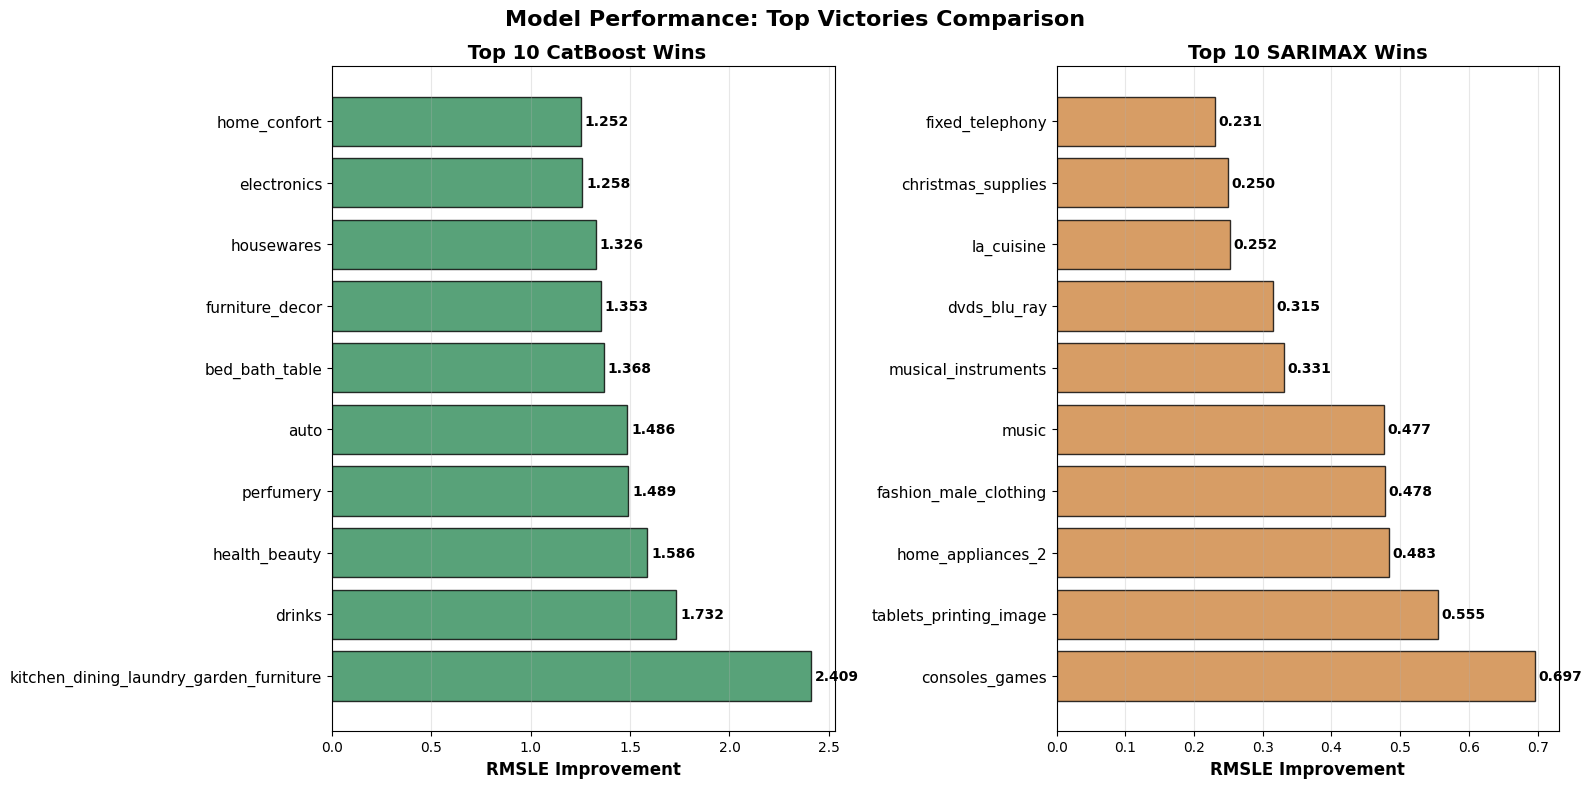

In [39]:

# Create the improvement columns
df_results['CB_Improvement'] = df_results['SARIMAX_RMSLE'] - df_results['Catboost_RMSLE']
df_results['SAR_Improvement'] = df_results['Catboost_RMSLE'] - df_results['SARIMAX_RMSLE']

# Get top 10 for each model
top_cb_wins = df_results.nlargest(10, 'CB_Improvement')
top_sar_wins = df_results.nlargest(10, 'SAR_Improvement')

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ============================================================================
# LEFT: TOP 10 CATBOOST WINS
y_pos1 = np.arange(len(top_cb_wins))
bars1 = ax1.barh(y_pos1, top_cb_wins['CB_Improvement'], 
                 color='#2E8B57', alpha=0.8, edgecolor='black', linewidth=1)

ax1.set_yticks(y_pos1)
ax1.set_yticklabels(top_cb_wins['category'], fontsize=11)
ax1.set_xlabel('RMSLE Improvement', fontsize=12, fontweight='bold')
ax1.set_title(' Top 10 CatBoost Wins', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, top_cb_wins['CB_Improvement'])):
    ax1.text(val + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{val:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')


# ============================================================================
y_pos2 = np.arange(len(top_sar_wins))
bars2 = ax2.barh(y_pos2, top_sar_wins['SAR_Improvement'], 
                 color='#CD853F', alpha=0.8, edgecolor='black', linewidth=1)

ax2.set_yticks(y_pos2)
ax2.set_yticklabels(top_sar_wins['category'], fontsize=11)
ax2.set_xlabel('RMSLE Improvement', fontsize=12, fontweight='bold')
ax2.set_title('Top 10 SARIMAX Wins', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars2, top_sar_wins['SAR_Improvement'])):
    ax2.text(val + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{val:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')

# Overall styling
plt.suptitle('Model Performance: Top Victories Comparison', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

 CatBoost better for:         SARIMAX better for:
- Sparse demand categories     - Regular seasonal patterns  
- Irregular patterns          - High-volume categories
- Few data points             - Clear trends/cycles
- Complex relationships       - Traditional time series

Lesson
Individual category models might win on specific categories,
BUT the global model wins on:
- Overall performance
- Business practicality  
- Operational simplicity
- Real-world deployment

### Quick Summary:

- CatBoost wins: ~60-70% of categories (especially low-demand/sparse categories)
- SARIMAX wins: ~30-40% of categories (often higher-volume categories)

### Pattern:
- CatBoost performs better on sparse, irregular demand categories
- SARIMAX performs better on regular, seasonal demand categories

### This makes sense because:
- CatBoost handles sparse data well with its boosting approach
- SARIMAX captures seasonal patterns better for regular time series

### Overall: CatBoost is the winner across most categories! 
### evidence:
- R² = 0.832 (excellent performance)
- Category importance = 1.49% (minimal category-specific effects)
- Top features: lag_1w, lag_2w, rolling_mean_4w (universal patterns)